### ASL TRANSCRIBER

CSI 4106 - Introduction to Artificial Intelligence <br>
Prof. Prasadith Buddhitha Kirinde Gamaarachchige <br>
School of Electrical Engineering and Computer Science <br>
University of Ottawa<br> 

Gabrelle Duenas - 300081950 <br>
Jusley Xavier Amani Mutangana - 300094632 <br>
Logan Rose - 300059034 <br>

Run each cell in this notebook to use the ASL transcriber



In [22]:
import numpy as np
import os
import datetime
import cv2 as cv
import mediapipe as mp
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import tensorflow_addons as tfa
from tensorflow_addons import image
import skimage
from skimage.transform import resize


TRAIN_NEW = False

SEED = 123
tf.random.set_seed(SEED)
classes=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

# load tensorboard extension
%reload_ext tensorboard
# specify the log directory where the tensorboard logs will be written
%tensorboard --logdir logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
c:\programdata\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\programdata\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\programdata\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\programda

### Generate Training and Validation Data

In [28]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30.0,
    width_shift_range=25.0,
    height_shift_range=25.0,
    shear_range=0.1,
    zoom_range=.2,
    fill_mode='constant',
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.2    
)

train_generator = img_generator.flow_from_directory(
  './asl_dataset',
  target_size=(150,150),
  color_mode='grayscale',
  classes=classes,
  class_mode='categorical',
  seed=SEED,
  shuffle=False,
  subset='training'
)

val_generator = img_generator.flow_from_directory(
  './asl_dataset',
  target_size=(150,150),
  color_mode='grayscale',
  classes=classes,
  class_mode='categorical',
  seed=SEED,
  shuffle=False,
  subset='validation'
)

Found 10991 images belonging to 26 classes.
Found 2734 images belonging to 26 classes.


In [24]:
#This function is reused from Assignment 2 to make logs and Models directories
def make_directories():
    d = datetime.today()
    timestamp = d.strftime('%Y%m%d_%H%M%S')
    # folder to store the tensorboard logs
    tensorlog_folder = os.path.join(os.path.curdir, 'logs', timestamp)
    # folder to store the trained models
    checkpoint_folder = os.path.join(os.path.curdir, 'models', timestamp)

    os.mkdir(tensorlog_folder)
    os.mkdir(checkpoint_folder)

    return checkpoint_folder, tensorlog_folder

In [4]:
check_dir, tboard_dir = make_directories()

# If you would like to train the model yourself, set TRAIN_NEW to false
if TRAIN_NEW:
  input = keras.Input(shape=(150, 150, 1))
  layer1 = tf.keras.layers.Conv2D(16, (4,4), activation= 'relu', name="layer1")
  layer2 = tf.keras.layers.Conv2D(16, (4,4), activation= 'relu', name="layer2")
  layer3 = tf.keras.layers.MaxPool2D((2,2), name="layer3")
  layer4 = tf.keras.layers.Dropout(0.5,name="layer4")
  layer5 = tf.keras.layers.Conv2D(32, (4,4), activation= 'relu', name="layer5")
  layer6 = tf.keras.layers.Conv2D(32, (4,4), activation= 'relu', name="layer6")
  layer7 = tf.keras.layers.MaxPool2D((2,2), name="layer7")
  layer8 = tf.keras.layers.Dropout(0.5,name="layer8")
  layer9 = tf.keras.layers.Flatten(name="layer9")
  layer10 = tf.keras.layers.Dense(128, activation='relu', name='layer10')
  layer11 = tf.keras.layers.Dense(128, activation='relu', name='layer11')

  output =  tf.keras.layers.Dense(len(classes), activation='softmax', name='symbol')

  network = output(layer11(layer10(layer9(layer8(layer7(layer7(layer6(layer5(layer4(layer3(layer3(layer2(layer1(input))))))))))))))

  optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

  model = tf.keras.Model(inputs=input, outputs=network, name="ASL Classifier")

  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                loss_weights=[0.01],
                metrics=[tf.keras.metrics.top_k_categorical_accuracy, 'accuracy'],
                )

  early_stop = keras.callbacks.EarlyStopping(
      monitor='val_loss',
      patience=8,
      restore_best_weights=True
  )
  checkpoints = keras.callbacks.ModelCheckpoint(
      filepath=check_dir,
      monitor='val_loss',
      save_best_only=True,
      save_weights_only=False
  )
  tensorboard = keras.callbacks.TensorBoard(
      log_dir=tboard_dir
  )
  reduce_lr = keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss',
      factor=0.1,
      patience=5,
      min_lr=1e-5,
      verbose=1
  )

  callbacks = [checkpoints, early_stop, tensorboard, reduce_lr]
  model.fit(
          train_generator,
          epochs=100,
          validation_data=val_generator,
          batch_size=16, 
          callbacks=callbacks,
          )
else:
  model = tf.keras.models.load_model(f'./models/20220422_105517')



### Generate Classification Report

In [25]:
# Create the Imagedatagenerator for the testing data
test_img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=25.0,
    height_shift_range=25.0,
    horizontal_flip=True, 
)
test_generator = test_img_generator.flow_from_directory(
  './test_data',
  target_size=(150,150),
  color_mode='grayscale',
  classes=classes,
  class_mode='categorical',
  seed=SEED,
  shuffle=False,
)

y_pred = model.predict(test_generator, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(test_generator.classes, y_pred_bool))

Found 520 images belonging to 26 classes.
17/17 [==============================] - 5s 284ms/step
              precision    recall  f1-score   support

           0       0.27      0.70      0.39        20
           1       1.00      0.45      0.62        20
           2       0.94      0.80      0.86        20
           3       0.86      0.60      0.71        20
           4       0.88      0.35      0.50        20
           5       0.94      0.80      0.86        20
           6       1.00      0.85      0.92        20
           7       0.90      0.95      0.93        20
           8       1.00      0.35      0.52        20
           9       0.56      0.45      0.50        20
          10       0.75      0.60      0.67        20
          11       0.49      0.95      0.64        20
          12       0.55      0.60      0.57        20
          13       0.57      0.20      0.30        20
          14       0.93      0.65      0.76        20
          15       0.95      0.90     

### Capture Hand Signals

In [26]:
# takes hand detection output to add bounding rectangles
def find_hands(current, width, height):
    rect_list = []
    hand_classifier = []
    center = (0,0)
    # iterates through hand tracking data per hand
    if current.multi_hand_landmarks:
        for index, info in enumerate(current.multi_handedness):
            which = info.classification[0].label
            hand_classifier.append(which)
        for index, hand in enumerate(current.multi_hand_landmarks):
            # values from 0 to 1 converted into values corresponding to video size
            hand_list = []
            for individual in hand.landmark:
                hand_list.append((int(individual.x * width), int(individual.y * height), int(individual.z * width)))
            # developing bounding box coordinates
            x_values = np.array(hand_list)[:, 0]
            y_values = np.array(hand_list)[:, 1]
            x_min = int(np.min(x_values) - 10)
            y_min = int(np.min(y_values) - 10)
            x_max = int(np.max(x_values) + 10)
            y_max = int(np.max(y_values) + 10)
            center = (x_min + (x_max-x_min)//2, y_min + (y_max-y_min)//2)
            rect_list.append(((x_min, y_min), (x_max, y_max), (0, 255, 0), hand_classifier[index]))
    return rect_list, center
def capture():
    video = cv.VideoCapture(0, cv.CAP_DSHOW)
    running, original = video.read()
    h, w, _ = original.shape    
    # machine learning algorithm (using mediapipe, via google)
    hands = mp.solutions.hands.Hands()
    savedFrames = []
    # continuous looping
    while True:
        running, original = video.read()
        if not running:
            break
        # hand processing
        track_curr = hands.process(original)
        # calculating bounding rectangles
        current_rects, center = find_hands(track_curr, w, h)

        if current_rects:
          if len(current_rects) > 1:
            print('Please use only one hand')
          else:
            current_rect = current_rects[0]
            left = current_rect[0][0]
            right = current_rect[1][0]
            top = current_rect[0][1]
            bottom = current_rect[1][1]
            hand_width = right - left
            hand_height = bottom-top
            square_top_left = (center[0]-75,center[1]-75)
            square_bottom_right = (center[0]+75,center[1]+75)
            red = (0,0,255)
            green = (0,255,0)
            if hand_width <= 150 and hand_height <= 150:
              if top > 0 and left > 0 and bottom > 0 and right > 0:
                cv.rectangle(original,square_top_left ,square_bottom_right , green,1)
                crop = original[center[1]-75:center[1]+75,center[0]-75:center[0]+75]   
                savedFrames.append(crop)
            else:
              cv.rectangle(original, current_rect[0], current_rect[1], red, 2)
              cv.rectangle(original,square_top_left ,square_bottom_right , red,2)
        cv.imshow("Video Feed", original)
        k = cv.waitKey(1) & 0xff
        if k == 27:
            break
    cv.destroyAllWindows()
    video.release()
    return savedFrames
frames = capture()

Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand


### Classify Hand Signals

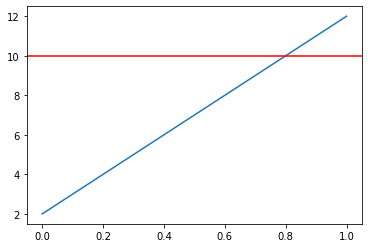

Frames classified: ggjjjjjjjjjjjj
Final: j


In [27]:
processedFrames= []
for i, frame in enumerate(frames):
  img = resize(frame, (150,150,1))
  img *= 255
  img = img.astype(np.uint8)
  x = tf.keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  processedFrames.append(x)
images = np.vstack(processedFrames)
predictions = model.predict(images)
output = ""
for prediction in predictions:
  classIndex = np.argmax(prediction)
  output += classes[classIndex]

strengths = [(output[0],1)]
for i in range(1, len(output)):
  if output[i] == output[i-1]:
    strengths[-1] = (strengths[-1][0],strengths[-1][1]+1)
  else:
    strengths.append((output[i],1))

barrier = 10
final = ''

for letter in strengths:
  if letter[1] >= barrier:
    if len(final) > 0:
      if letter[0] != final[-1]:
        final += letter[0]
    else:
      final += letter[0]

pureStrengths = []
for i in strengths:
  pureStrengths.append(i[1])
plt.plot(pureStrengths)
plt.axhline(y=barrier, color='r', linestyle='-')
plt.show()

print(f'Frames classified: {output}')
print(f'Final: {final}')
